In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

import xgboost as xgb

# import efficientnet for feature extraction 
from efficientnet_pytorch import EfficientNet

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
# upload train dataframe
train_df_allsamples = pd.read_csv("../TrainTestDataFrames/marking.csv")
train_df_allsamples.head()
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

In [4]:
# create dictionary that maps image name to target 
image_names = train_df_allsamples["image_id"].values 
targets = train_df_allsamples["target"].values
img_to_target = {image_name:target for image_name, target in zip(image_names, targets)}

percent_tp = sum(targets)/len(targets) * 100 
print("{} training samples total.".format(len(targets)))
print("Only {:.3f} percent of training data set is a true positive.".format(percent_tp))
print("Therefore, the baseline accuracy is {:.3f}".format(np.max([percent_tp, 100-percent_tp])))

60487 training samples total.
Only 9.058 percent of training data set is a true positive.
Therefore, the baseline accuracy is 90.942


In [5]:
# update so that the number of positives balances negatives
train_df_pos = train_df_allsamples.iloc[targets>0, :]
train_df_neg = train_df_allsamples.iloc[targets==0, :]
train_df_negsample = train_df_neg.sample(n=int(train_df_pos.shape[0]))

# concatenate negative and positive samples, then shuffle using .sample() 
#train_val_df = pd.concat((train_df_pos, train_df_negsample)).sample(frac=1)
train_val_df = train_df_allsamples.sample(frac=.1)

train_val_split = .95
n_train_val = train_val_df.shape[0]
n_train = int(train_val_split*n_train_val)

train_df = train_val_df[:n_train]
val_df = train_val_df[n_train:]

# create dictionary that maps image name to target 
image_names = val_df["image_id"].values 
val_targets = val_df["target"].values

percent_tp = sum(val_targets)/len(val_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])

print("{} Training and {} Validation samples".format(n_train, n_train_val-n_train))
print("{:.3f} percent of validation data set is a positive.".format(percent_tp))
print("Baseline validation accuracy is {:.3f}".format(baseline))

5746 Training and 303 Validation samples
7.921 percent of validation data set is a positive.
Baseline validation accuracy is 92.079


In [6]:
# import efficientnet model 
model = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [7]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# define a unique transform each time a positive is resampled: 

# basic transform 
transform_1 = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# vertical flip 
transform_2 = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# horizontal flip 
transform_3 = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# vertical and horizontal flip (same as rotating 180 deg... but hopefully still useful)
transform_4 = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

def make_weights_for_balanced_classes(df, nclasses=2):   
    targets = df["target"].values
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[label] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[label]                                  
    return weight  

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_1(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class MyDataLoader():
    def __init__(self, df, path, batchsize):
        # store df, path, weights, ...
        self.df = df 
        self.path = path
        self.w = np.array(make_weights_for_balanced_classes(df))
        self.batchsize = batchsize 
        self.balanced = True
        
        # create a dictionary to map image_ids to index and target in dataframe 
        image_ids = self.df['image_id'].values 
        self.targets = self.df['target'].values
        inds = np.arange(len(image_ids))
        self.imgID2Idx = {im_id:ind for (im_id, ind) in zip(image_ids, inds)}
        self.imgID2Target = {im_id:target for (im_id, target) in zip(image_ids, self.targets)}
        
        # keep track of how many times samples have been drawn 
        self.counts = np.zeros(len(image_ids))
        
    def get_batch(self):
        # get image ids for the batch 
        if np.sum(self.w > 0) >= self.batchsize:
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        else:
            # update batchsize 
            print("Updating batchsize, maximum dataset size reached")
            self.batchsize = np.sum(self.w > 0)
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        
        # get the index locations for the image ids 
        batch_sample_inds = [self.imgID2Idx[im_id] for im_id in batch_image_ids]
        batch_targets = [self.imgID2Target[im_id] for im_id in batch_image_ids]
        
        # Update counts 
        self.counts[batch_sample_inds] += 1
        
        # Update sampling weights so that target=0 --> w = 0, target=1 --> w /= 2 
        for ind, target in zip(batch_sample_inds, batch_targets):
            # if the sample is a negative, then we don't want to sample it again 
            # if the sample has been sampled more than 3 times, it shouldn't be sampled again
            # if target is positive, sampling should happen less frequently 
            if target == 0 or self.counts[ind] > 3:
                self.w[ind] = 0 
            else:
                self.w[ind] /= 2 
        
        # Data returned in shape [Batchsize, Channels, H, W]
        images = np.zeros((self.batchsize, 3, 256, 256)) 
        labels = np.zeros(self.batchsize)
        meta_data = np.zeros((self.batchsize, 3))
        
        for i, index in enumerate(batch_sample_inds):
            
            # 1. load image
            img_name = self.df['image_id'].values[index]
            img_path = self.path + img_name + ".jpg"
            img = plt.imread(img_path)

            # 2. Preprocess the data (e.g. torchvision.Transform).
            img = Image.fromarray(img)
            if self.counts[index] == 1:
                images[i, :, :, :] = transform_1(img)
            if self.counts[index] == 2:
                images[i, :, :, :] = transform_2(img)
            if self.counts[index] == 3:
                images[i, :, :, :] = transform_3(img)
            if self.counts[index] == 4:
                images[i, :, :, :] = transform_4(img)
                
            # 3. store label 
            labels[i] = self.imgID2Target[img_name]
                
            # 4. get meta_data 
            meta = self.df[meta_features].values[index]
            meta_data[i, :] = np.array([encoder[str(m)] for m in meta])
                
        # Quit once all positive samples have zero valued weights 
        if np.sum(self.w[self.targets==1]) == 0:
            self.balanced = False
        
        # return data 
        X = torch.tensor(images, dtype = torch.float32)
        y = torch.tensor(labels, dtype = torch.float32)
        return X, y, meta_data

In [8]:
# Use the custom data loader.
batchsize = 4 

train_loader = MyDataLoader(train_df, path, batchsize=batchsize)
while train_loader.balanced:
    images, labels, meta_data = train_loader.get_batch()

    # Forward pass
    images = images.to(device)
    embed = model(images)
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data), axis=1)

    # append the dataset
    try:
        X = np.concatenate((X, batch_features), 0)
        y = np.append(y, labels.numpy())
    except:
        X = batch_features 
        y = labels.numpy() 

In [17]:
print("Balance of positives in dataset: {:.3f}".format(sum(y)/len(y)))

Balance of positives in dataset: 0.292


In [9]:
# Empty GPU cache 
torch.cuda.empty_cache()

# Save X and y in pandas dataframe 
XGB_data = pd.DataFrame(data=X)
XGB_data['targets'] = y 
XGB_data.to_csv("XGB_ENet_train.csv", index=False)
#XGB_data = pd.read_csv("XGB_ENet_train.csv")

X = np.array(XGB_data.values[:, :-1], np.float32) 
y = np.array(XGB_data['targets'].values, np.float32)

In [10]:
# weight positive examples more heavily 
def make_weights(targets, nclasses=2):   
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[np.int(label)] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[np.int(label)]                                  
    return np.array(weight)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21)

# weight positive examples more heavily 
w = make_weights(y_train)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=w)
dval = xgb.DMatrix(X_val, label=y_val) 

# booster params 
param = {'max_depth': 16, 'eta': .1, 'objective': 'binary:logistic'}
param['nthread'] = 8
param['eval_metric'] = 'auc'
param['subsample'] = .8
#param['gpu_id'] = 0
#param['tree_method'] = 'gpu_hist'

# specify validation set 
evallist = [(dval, 'eval')]

# Training 
num_round = 5000
bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=5)

[21:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0 pruned nodes, max_depth=20
[0]	eval-auc:0.663301
Will train until eval-auc hasn't improved in 5 rounds.
[21:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 788 extra nodes, 0 pruned nodes, max_depth=20
[1]	eval-auc:0.69827
[21:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=20
[2]	eval-auc:0.713561
[21:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=20
[3]	eval-auc:0.72598
[21:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 0 pruned nodes, max_depth=20
[4]	eval-auc:0.734586
[21:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 0 pruned nodes, max_depth=20
[5]	eval-auc:0.73919
[21:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=20
[6]	eval-auc:0.747

[21:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=15
[60]	eval-auc:0.816236
[21:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=13
[61]	eval-auc:0.81649
[21:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=15
[62]	eval-auc:0.816953
[21:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=15
[63]	eval-auc:0.817267
[21:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=13
[64]	eval-auc:0.817605
[21:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=13
[65]	eval-auc:0.817578
[21:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=17
[66]	eval-auc:0.817804
[21:29:27] src/tree/updater_prune.cc:74: t

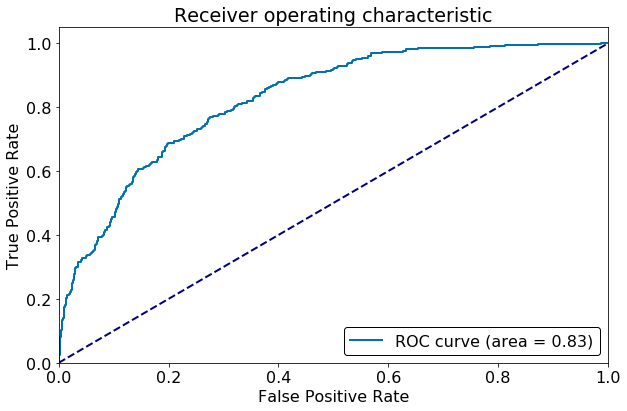

In [27]:
# prediction 
ypred = bst.predict(dval) 

fpr, tpr, _ = roc_curve(y_val, ypred)
roc_auc = auc(fpr, tpr)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [14]:
valid_dataset = ValidDataset(val_df, path)                                               
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batchsize)   

model = model.eval()
for i, (images, meta_data, labels) in enumerate(valid_loader):
    images = images.to(device)

    # Forward pass
    embed = model(images)
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data.numpy()), axis=1)
    
    # append the dataset
    try:
        Xval = np.concatenate((Xval, batch_features), 0)
        yval = np.append(yval, labels.numpy())
    except:
        Xval = batch_features 
        yval = labels.numpy() 
        
XGB_data = pd.DataFrame(data=Xval)
XGB_data['targets'] = yval 
XGB_data.to_csv("XGB_ENet_val.csv", index=False)

XGB_data = pd.read_csv("XGB_ENet_val.csv")
Xval = np.array(XGB_data.values[:, :-1], np.float32) 
yval = np.array(XGB_data['targets'].values, np.float32)

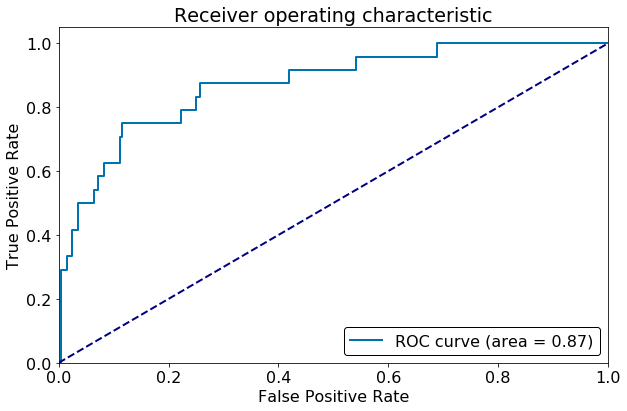

In [23]:
dtest = xgb.DMatrix(Xval)
ypred = bst.predict(dtest)

fpr, tpr, _ = roc_curve(yval, ypred)
roc_auc = auc(fpr, tpr)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [24]:
val_acc = accuracy_score(yval, np.round(ypred))
print("validation accuracy: {:.3f}".format(val_acc))

validation accuracy: 0.901


In [ ]:
#bst.save_model("../Models/xgbENet.model")